<a href="https://colab.research.google.com/github/HenryLiu0405/Stock-Price-Prediction/blob/main/Stock_Price_Predition.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import sklearn
from sklearn.preprocessing import scale
from sklearn.decomposition import PCA
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import OneHotEncoder
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import PolynomialFeatures
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import r2_score

In [2]:
#open to browse the file
from google.colab import files
uploaded = files.upload()

Saving HistoricalData.csv to HistoricalData.csv


In [3]:
#content
import pandas as pd # Import the pandas library
Filename = 'HistoricalData.csv'
df = pd.read_csv(Filename)  #utf-8

# Pre-treatment

Bsic data cleaning

In [12]:
# Remove duplicate rows if any
df.drop_duplicates(inplace=True)

# Check for missing values and drop rows with NaN
df.dropna(inplace=True)

# Convert columns with mixed types to string first, then remove currency symbols and commas
# Process 'Close/Last', 'Open', 'High', 'Low' columns
for col in ['Close/Last', 'Open', 'High', 'Low']:
    # Convert the entire column to string type
    df[col] = df[col].astype(str)
    # Remove dollar signs and commas
    df[col] = df[col].str.replace('$', '')
    # Convert to float
    df[col] = df[col].astype(float)

# Display the data types after processing
print("\nData types after processing:")
print(df.dtypes)


Data types after processing:
Close/Last    float64
Volume          int64
Open          float64
High          float64
Low           float64
year            int32
month           int32
day             int32
quarter         int32
dtype: object


Date processing and time feature extraction

In [17]:
# Display the column names of the DataFrame
print("Column names in the DataFrame:")
print(df.columns.tolist())
print(df.head())

Column names in the DataFrame:
['Close/Last', 'Volume', 'Open', 'High', 'Low', 'year', 'month', 'day', 'quarter']
            Close/Last    Volume     Open      High       Low  year  month  \
Date                                                                         
2025-05-16      454.27  23849780  452.050  454.3600  448.7300  2025      5   
2025-05-15      453.13  21992320  450.765  456.1900  450.4301  2025      5   
2025-05-14      452.94  19902800  448.140  453.9000  448.1400  2025      5   
2025-05-13      449.14  23618820  447.780  450.6733  445.3600  2025      5   
2025-05-12      449.26  22821940  445.940  449.3700  439.7800  2025      5   

            day  quarter  
Date                      
2025-05-16   16        2  
2025-05-15   15        2  
2025-05-14   14        2  
2025-05-13   13        2  
2025-05-12   12        2  


Technical calculation index

In [20]:
# Feature engineering
# Calculate moving averages
df['close_ma_7'] = df['Close/Last'].rolling(window=7).mean()
df['close_ma_30'] = df['Close/Last'].rolling(window=30).mean()

# Calculate daily return
df['daily_return'] = df['Close/Last'].pct_change()

# Calculate RSI (Relative Strength Index)
delta = df['Close/Last'].diff()
gain = (delta.where(delta > 0, 0)).rolling(window=14).mean()
loss = (-delta.where(delta < 0, 0)).rolling(window=14).mean()
rs = gain / loss
df['RSI'] = 100 - (100 / (1 + rs))

# Calculate Bollinger Bandsmiddle
middle_band = df['Close/Last'].rolling(window=20).mean()
upper_band = middle_band + 2 * df['Close/Last'].rolling(window=20).std()
lower_band = middle_band - 2 * df['Close/Last'].rolling(window=20).std()

df['middle_band'] = middle_band
df['upper_band'] = upper_band
df['lower_band'] = lower_band

Standardization of features

In [21]:
# Feature scaling
# Initialize the StandardScaler
scaler = StandardScaler()

# Scale the 'Close/Last' price and 'Volume'
df[['close_scaled', 'volume_scaled']] = scaler.fit_transform(df[['Close/Last', 'Volume']])

Reprocess missing values

In [22]:
# Drop rows with NaN values resulting from rolling window calculations
df.dropna(inplace=True)

Print data after process

In [23]:
print(df.head())

            Close/Last    Volume     Open    High     Low  year  month  day  \
Date                                                                          
2025-04-04      359.84  49209850  364.125  374.59  359.48  2025      4    4   
2025-04-03      373.11  30198000  374.785  377.48  369.35  2025      4    3   
2025-04-02      382.14  16092560  377.965  385.08  376.62  2025      4    2   
2025-04-01      382.19  19689500  374.650  382.85  373.23  2025      4    1   
2025-03-31      375.39  35184680  372.535  377.07  367.24  2025      3   31   

            quarter  close_ma_7  close_ma_30  daily_return        RSI  \
Date                                                                    
2025-04-04        2  374.337143   403.485667      0.005533  36.607815   
2025-04-03        2  372.237143   400.780333      0.036878  44.466973   
2025-04-02        2  371.335714   398.414000      0.024202  53.116204   
2025-04-01        2  371.455714   396.055667      0.000131  56.577934   
2025-03-

# Prophet for Long Trend

In [25]:
!pip install prophet
from prophet import Prophet

In [37]:
df_prophet = df.reset_index()
df_prophet.rename(columns={'index': 'Date'}, inplace=True)

Create a new DataFrame with a date and closing price

In [47]:
prophet_df = df.reset_index()[['Date', 'Close/Last']]
# The column names required for Prophet are 'ds' and' y '
prophet_df.columns = ['ds', 'y']

Initialize Prophet model

In [39]:
model = Prophet(
    yearly_seasonality=True,  # Consider the seasonality of the year
    weekly_seasonality=True,  # Consider the seasonality of the week
    daily_seasonality=False,  # Without considering seasonality, the stock market usually only trades on weekdays
    changepoint_prior_scale=0.5  # adjust trend change points flexibility
)

Fitted model

In [40]:
model.fit(prophet_df)

DEBUG:cmdstanpy:input tempfile: /tmp/tmpaa78x317/jan5v7wr.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpaa78x317/vbncf4od.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.11/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=94100', 'data', 'file=/tmp/tmpaa78x317/jan5v7wr.json', 'init=/tmp/tmpaa78x317/vbncf4od.json', 'output', 'file=/tmp/tmpaa78x317/prophet_model0tj38hqx/prophet_model-20250522082649.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
08:26:49 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
08:26:51 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing


Create a future database

            index  Close/Last    Volume     Open    High     Low  year  month  \
Date                                                                            
2025-04-04      0      359.84  49209850  364.125  374.59  359.48  2025      4   
2025-04-03      1      373.11  30198000  374.785  377.48  369.35  2025      4   
2025-04-02      2      382.14  16092560  377.965  385.08  376.62  2025      4   
2025-04-01      3      382.19  19689500  374.650  382.85  373.23  2025      4   
2025-03-31      4      375.39  35184680  372.535  377.07  367.24  2025      3   

            day  quarter  ...  daily_return        RSI  middle_band  \
Date                      ...                                         
2025-04-04    4        2  ...      0.005533  36.607815     383.3050   
2025-04-03    3        2  ...      0.036878  44.466973     380.1965   
2025-04-02    2        2  ...      0.024202  53.116204     378.0335   
2025-04-01    1        2  ...      0.000131  56.577934     377.3800   
2025-0

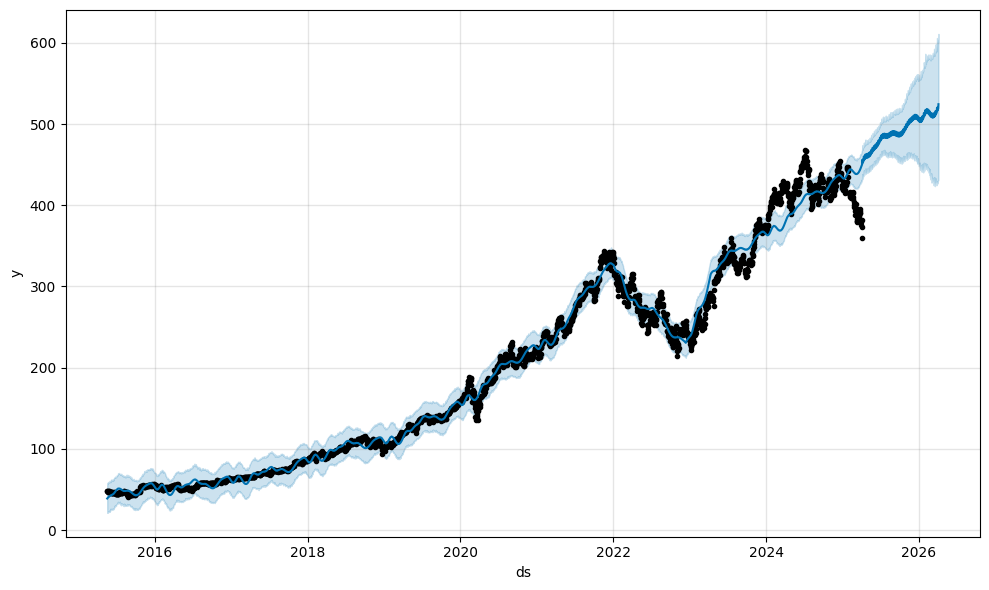

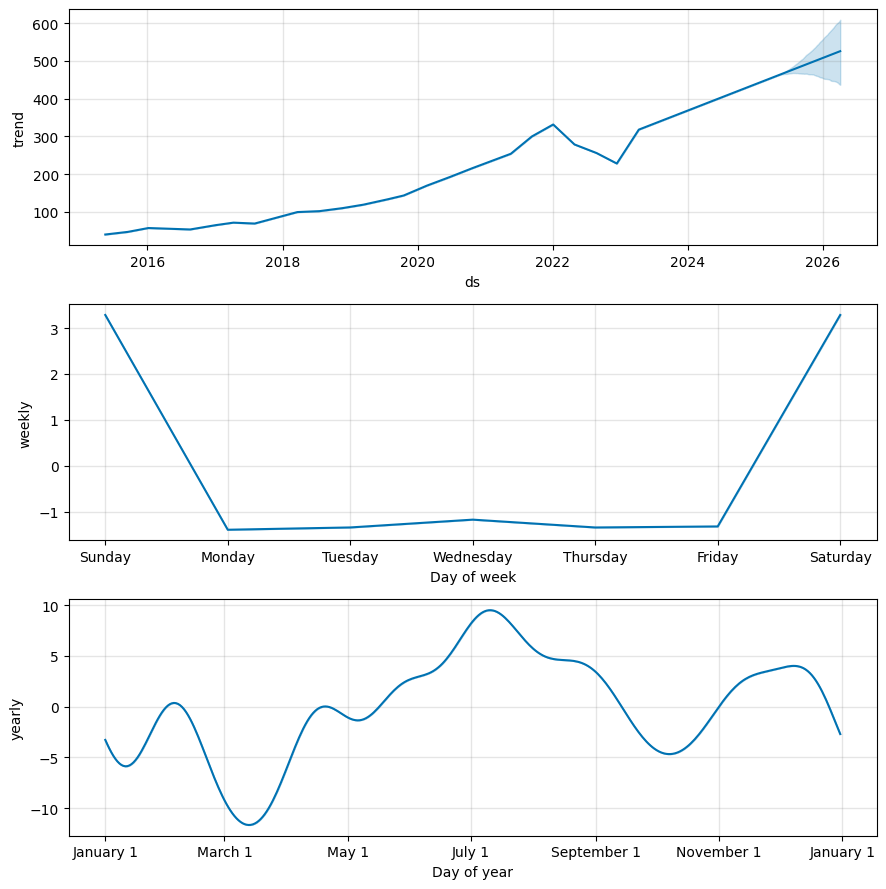

In [49]:
future = model.make_future_dataframe(periods=365)
forecast = model.predict(future) # predict

# extract trend and seasonality items
trend = forecast[['ds', 'trend']]
seasonality = forecast[['ds', 'yearly', 'weekly']]

# Merge trends and seasonal items
prophet_features = pd.merge(trend, seasonality, on='ds')
prophet_features.rename(columns={'yearly': 'yearly_seasonality', 'weekly': 'weekly_seasonality'}, inplace=True)

# Merge the features extracted by Prophet into the original data box
df_prophet = pd.merge(df.reset_index(), prophet_features, left_on='Date', right_on='ds')
df_prophet.set_index('Date', inplace=True)
df_prophet.drop('ds', axis=1, inplace=True)

# Display the merged data box
print(df_prophet.head())

# Visualize Prophet's prediction results and components
fig1 = model.plot(forecast)
fig2 = model.plot_components(forecast)
plt.show()

# feature fusion

Merge the original features with the features extracted by Prophet

# LSTM & Random Forest

Random Forest